# Overfitting demo

## Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [106]:
# import graphlab
import turicreate as tc
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

In [141]:
# turicreate lacks KFOLDs
# source: https://github.com/Kagandi/turicreate-cross-validation/blob/master/turicreate_cross_validation/cross_validation.py

# import turicreate_cross_validation as tcv

# from turicreate_cross_validation import shuffle_sframe, StratifiedKFold, cross_val_score

# -*- coding: utf-8 -*-
"""
This module API is mostly compatible with the old graphlab-create cross_validation module.
https://turi.com/products/create/docs/graphlab.toolkits.cross_validation.html
"""
import numpy as np
import turicreate as tc
from collections import defaultdict
from turicreate.toolkits._internal_utils import _raise_error_if_column_exists
from turicreate.toolkits._main import ToolkitError


def _get_classification_metrics(model, targets, predictions):
    """

    Parameters
    ----------
    model: Classifier
        Turi create trained classifier.
    targets: SArray
        Array containing the expected labels.
    predictions: SArray
        Array containing the predicted labels.

    Returns
    -------
    dict
        An average metrics of the n folds.

    """
    precision = tc.evaluation.precision(targets, predictions)
    accuracy = tc.evaluation.accuracy(targets, predictions)
    recall = tc.evaluation.recall(targets, predictions)
    auc = tc.evaluation.auc(targets, predictions)
    return {"recall": recall,
            "precision": precision,
            "accuracy": accuracy,
            "auc": auc
            }


def _kfold_sections(data, n_folds):
    """
    Calculate the indexes of the splits that should
    be used to split the data into n_folds.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.


    Yields
    -------
    (int, int)
        Yields the first and last index of the fold.

    Notes
    -----
        Based on scikit implementation.
    """
    Neach_section, extras = divmod(len(data), n_folds)
    section_sizes = ([0] +
                     extras * [Neach_section + 1] +
                     (n_folds - extras) * [Neach_section])
    div_points = np.array(section_sizes).cumsum()
    for i in range(n_folds):
        st = div_points[i]
        end = div_points[i + 1]
        yield st, end


def shuffle_sframe(sf, random_seed=None, temp_shuffle_col="shuffle_col"):
    """
    Create a copy of the SFrame where the rows have been shuffled randomly.

    Parameters
    ----------
    sf: SFrame
        A Non empty SFrame.
    random_seed: int, optional
        Random seed to use for the randomization. If provided, each call
        to this method will produce an identical result.
    temp_shuffle_col: str, optional
        Change only if you use the same column name.

    Returns
    -------
    SFrame
        A randomly shuffled SFrame.

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> shuffle_sframe(sf)
    """

    if temp_shuffle_col in sf.column_names():
        raise ToolkitError('The SFrame already contains column named {0}. '
                           'Please enter set another value to temp_shuffle_col'.format(temp_shuffle_col))
    shuffled_sframe = sf.copy()
    shuffled_sframe[temp_shuffle_col] = tc.SArray.random_integers(sf.num_rows(), random_seed)
    return shuffled_sframe.sort(temp_shuffle_col).remove_column(temp_shuffle_col)


def KFold(data, n_folds=10):
    """
    Create a K-Fold split of a data set as an iterable/indexable object of K pairs,
    where each pair is a partition of the dataset.  This can be useful for cross
    validation, where each fold is used as a held out dataset while training
    on the remaining data.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.

    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.

    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = KFold(sf)
    """
    if data.num_rows() < n_folds:
        raise ValueError
    for st, end in _kfold_sections(data, n_folds):
        idx = np.zeros(len(data))
        idx[st:end] = 1
        yield data[tc.SArray(1 - idx)], data[tc.SArray(idx)]


def StratifiedKFold(data, label='label', n_folds=10):
    """
    Create a Stratified K-Fold split of a data set as an iteratable/indexable object
    of K pairs, where each pair is a partition of the data set. This can be useful
    for cross validation, where each fold is used as a heldout dataset while
    training on the remaining data. Unlike the regular KFold the folds are
    made by preserving the percentage of samples for each class.
    The StratifiedKFold is more suitable for smaller datasets
    or for datasets where there a is a minority class.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    label: str
        The target/class column name in the SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.

    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.

    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
    """
    _raise_error_if_column_exists(data, label, 'data', label)

    labels = data[label].unique()
    labeled_data = [data[data[label] == l] for l in labels]
    fold = [KFold(item, n_folds) for item in labeled_data]
    for _ in range(n_folds):
        train, test = tc.SFrame(), tc.SFrame()
        for f in fold:
            x_train, x_test = f.next()
            train = train.append(x_train)
            test = test.append(x_test)
        yield train, test


def cross_val_score(datasets, model_factory, model_parameters=None, evaluator=_get_classification_metrics):
    """
    Evaluate model performance via cross validation for a given set of parameters.

    Parameters
    ----------
    datasets: iterable of tuples
        The data used to train the model on a format of iterable of tuples.
        The tuples should be in a format of (train, test).
    model_factory: function
        This is the function used to create the model.
        For example, to perform model_parameter_search using the
        GraphLab Create model graphlab.linear_regression.LinearRegression,
        the model_factory is graphlab.linear_regression.create().
    model_parameters: dict
        The params argument takes a dictionary containing parameters that will be passed to the provided model factory.
    evaluator: function (model, training_set, validation_set) -> dict, optional
        The evaluation function takes as input the model, training and validation SFrames,
        and returns a dictionary of evaluation metrics where each value is a simple type, e.g. float, str, or int.

    Returns
    -------
    dict
        The calculate metrics for the cross validation.

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
        >>> params = {'target': 'label'}
        >>> cross_val_score(folds, tc.random_forest_classifier.create, params)
    """
    if not model_parameters:
        model_parameters = {'target': 'label'}
    label = model_parameters['target']

    cross_val_metrics = defaultdict(list)
    for train, test in datasets:

        _raise_error_if_column_exists(train, label, 'train', label)
        _raise_error_if_column_exists(test, label, 'test', label)

        model = model_factory(train, **model_parameters)
        prediction = model.predict(test)
        metrics = evaluator(model, test[label], prediction)
        for k, v in metrics.iteritems():
            cross_val_metrics[k].append(v)
    return {k: np.mean(v) for k, v in cross_val_metrics.iteritems()}

Create random values for x in interval [0,1)

In [142]:
random.seed(98103)
n = 30
x = tc.SArray([random.random() for i in range(n)]).sort()

Compute y

In [143]:
y = x.apply(lambda x: math.sin(4*x))

Add random Gaussian noise to y

In [144]:
random.seed(1)
e = tc.SArray([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into an SFrame to manipulate later

In [145]:
data = tc.SFrame({'X1':x,'Y':y})
data

X1,Y
0.03957894495006575,0.5870501910256387
0.04156809967912256,0.6486558513722105
0.0724319480800758,0.30780330948476986
0.1502890446221763,0.31074844741664676
0.16133414450223427,0.23740962549610656
0.19195631279497838,0.7050171572238372
0.23283391714465285,0.4617166769923188
0.25990098016580054,0.38326050785082555
0.3801458148686865,1.065176914291498
0.432444723507992,1.031847069489963


### Create a function to plot the data, since we'll do it many times

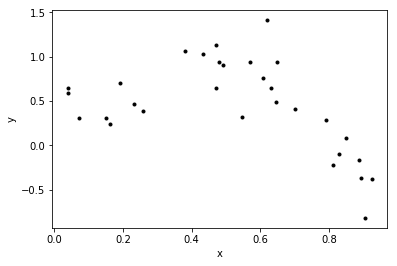

In [146]:
def plot_data(data):    
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [147]:
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [148]:
def polynomial_regression(data, deg):
    model = tc.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=0.,l1_penalty=0.,
                                              validation_set=None,verbose=False)
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [149]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = tc.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way :)

In [150]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1

    # Get learned parameters as a list
    w = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print('Learned polynomial for degree ' + str(deg) + ':')
    w.reverse()
    print(numpy.poly1d(w))

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [151]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [152]:
print_coefficients(model)

Learned polynomial for degree 2:
        2
-5.129 x + 4.147 x + 0.07471


Form and plot our predictions along a grid of x values:

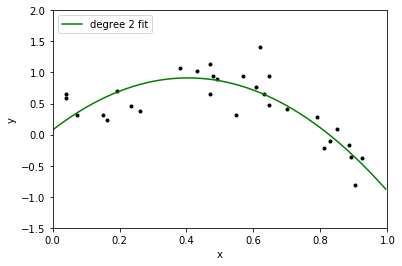

In [153]:
plot_poly_predictions(data, model)

## Fit a degree-4 polynomial

Learned polynomial for degree 4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


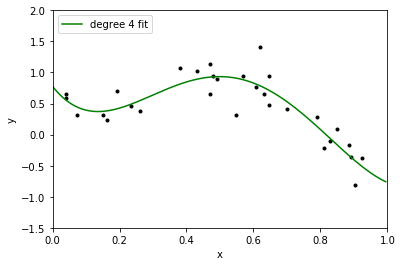

In [154]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)

## Fit a degree-16 polynomial

In [155]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:
          16             15             14             13
1.86e+05 x  - 1.557e+06 x  + 3.552e+06 x  - 6.337e+05 x 
              12             11            10             9
 - 8.639e+06 x  + 1.341e+07 x  - 7.48e+06 x  + 6.911e+05 x
              8             7             6             5             4
 - 7.244e+05 x + 3.045e+06 x - 2.904e+06 x + 1.372e+06 x - 3.696e+05 x
              3        2
 + 5.763e+04 x - 4900 x + 195.4 x - 2.229


###Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

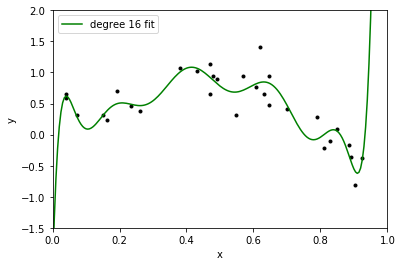

In [156]:
plot_poly_predictions(data, model)

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

# 

# 

 # 

 # 

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [157]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = tc.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=l2_penalty,
                                              validation_set=None,verbose=False)
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [158]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

Learned polynomial for degree 16:
          16             15             14             13
1.86e+05 x  - 1.557e+06 x  + 3.552e+06 x  - 6.337e+05 x 
              12             11            10             9
 - 8.639e+06 x  + 1.341e+07 x  - 7.48e+06 x  + 6.911e+05 x
              8             7             6             5             4
 - 7.244e+05 x + 3.045e+06 x - 2.904e+06 x + 1.372e+06 x - 3.696e+05 x
              3        2
 + 5.763e+04 x - 4900 x + 195.4 x - 2.229


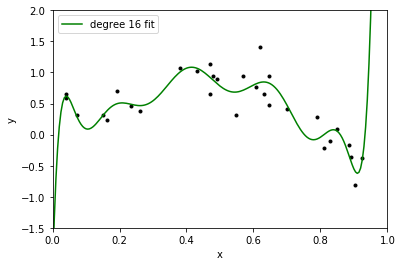

In [159]:
plot_poly_predictions(data,model)

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [160]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:
        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


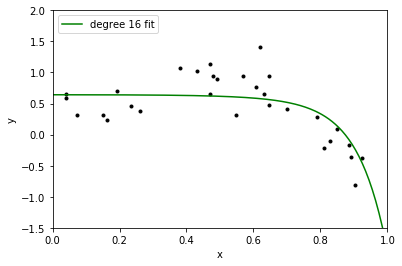

In [161]:
plot_poly_predictions(data,model)

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
Learned polynomial for degree 16:
          16             15             14             13
1.86e+05 x  - 1.557e+06 x  + 3.552e+06 x  - 6.337e+05 x 
              12             11            10             9
 - 8.639e+06 x  + 1.341e+07 x  - 7.48e+06 x  + 6.911e+05 x
              8             7             6             5             4
 - 7.244e+05 x + 3.045e+06 x - 2.904e+06 x + 1.372e+06 x - 3.696e+05 x
              3        2
 + 5.763e+04 x - 4900 x + 195.4 x - 2.229


lambda = 1.00e-10
Learned polynomial for degree 16:
           16             15             14             13
4.975e+04 x  - 7.821e+04 x  - 2.265e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.365e+04 x  + 3078 x  - 3.332e+04 x  - 2.786e+04 x + 1.033e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1437 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.1 x - 65.19 x + 2.159


lambda = 1.00e-06
Learned polyn

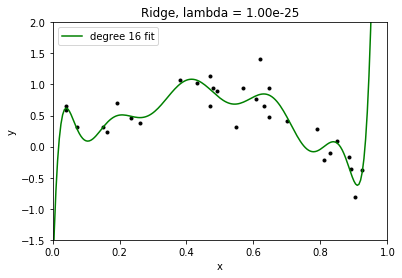

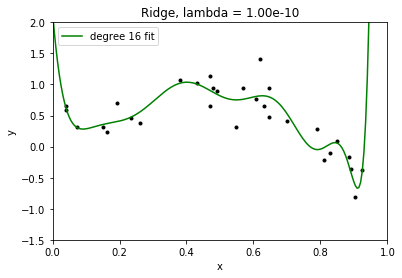

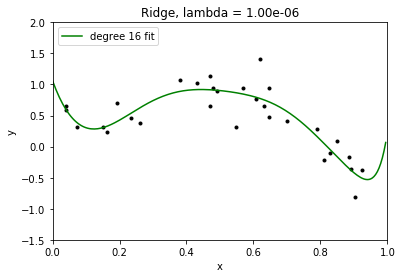

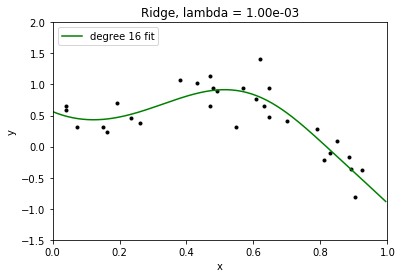

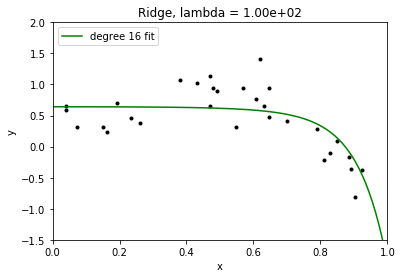

In [162]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print('lambda = %.2e' % l2_penalty)
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

In [163]:
data

X1,Y
0.03957894495006575,0.5870501910256387
0.04156809967912256,0.6486558513722105
0.0724319480800758,0.30780330948476986
0.1502890446221763,0.31074844741664676
0.16133414450223427,0.23740962549610656
0.19195631279497838,0.7050171572238372
0.23283391714465285,0.4617166769923188
0.25990098016580054,0.38326050785082555
0.3801458148686865,1.065176914291498
0.432444723507992,1.031847069489963


## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [203]:
# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    data = polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
#     folds = KFold(data, num_folds)
    
    # convert generator to array in memory
#     folds = [f for f in folds]
        
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in KFold(data, num_folds):
            # train model
            model = tc.linear_regression.create(train_set,
                                                target='Y', 
                                                l2_penalty=l2_penalty,
#                                                 l1_penalty=0.,
                                                validation_set=None,
                                                verbose=False)
            
            # predict on validation set 
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
        
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse, best_l2_penalty

Run LOO cross validation for "num" values of lambda, on a log scale

In [204]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse, best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

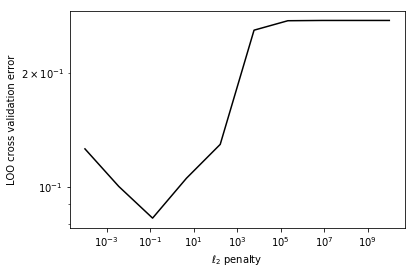

In [205]:
plt.plot(l2_penalty_values, l2_penalty_mse, 'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [206]:
best_l2_penalty

0.1291549665014884

In [207]:
l2_penalty_mse

[0.12595084968811382,
 0.10028936628986808,
 0.08274685851993187,
 0.10535836337232465,
 0.12943491467304286,
 0.25878646764394236,
 0.2740612061631873,
 0.2745184673176902,
 0.27453121749208825,
 0.2745315722939207]

In [208]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree 16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


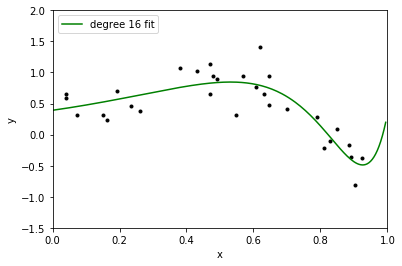

In [209]:
plot_poly_predictions(data, model)

# 

# 

# 

# 

# Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda (here called "L1_penalty").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [171]:
def polynomial_lasso_regression(data, deg, l1_penalty):
    model = tc.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=0.,
                                              l1_penalty=l1_penalty,
                                              validation_set=None, 
                                              solver='fista', verbose=False,
                                              max_iterations=3000, convergence_threshold=1e-10)
    return model

###### Explore the lasso solution as a function of a few different penalty strengths

We refer to lambda in the lasso case below as "l1_penalty"

l1_penalty = 1.000000e-04
number of nonzeros = 17
Learned polynomial for degree 16:
       16        15         14         13         12         11
29.02 x  + 1.35 x  - 12.72 x  - 16.93 x  - 13.82 x  - 6.698 x 
          10         9         8         7         6         5
 + 1.407 x  + 8.939 x + 12.88 x + 11.44 x + 3.759 x - 8.062 x
          4         3         2
 - 16.28 x - 7.682 x + 17.86 x - 4.384 x + 0.685


l1_penalty = 1.000000e-02
number of nonzeros = 14
Learned polynomial for degree 16:
        16            15           11          10         9          8
-1.182 x  - 0.001713 x  + 0.08724 x  + 0.7389 x  + 3.829 x + 0.4764 x
           7             6          5         4             3         2
 + 0.1287 x - 0.0001597 x - 0.6146 x - 10.11 x + 0.0005182 x + 6.686 x - 1.28 x + 0.5055


l1_penalty = 1.000000e-01
number of nonzeros = 5
Learned polynomial for degree 16:
       16          6        5
2.153 x  - 0.7958 x - 3.14 x + 1.224 x + 0.3459


l1_penalty = 1.000000e+01
numb

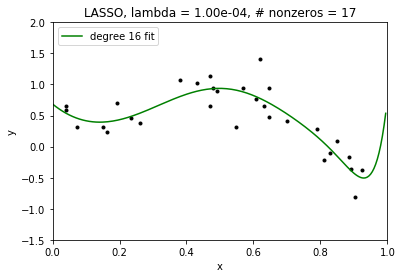

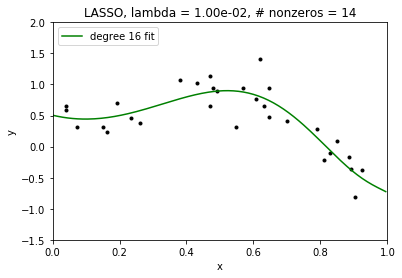

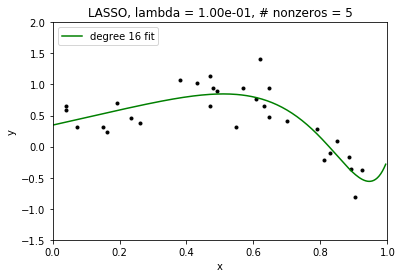

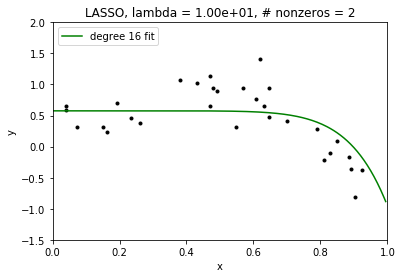

In [172]:
for l1_penalty in [0.0001, 0.01, 0.1, 10]:
    model = polynomial_lasso_regression(data, deg=16, l1_penalty=l1_penalty)
    print('l1_penalty = %e' % l1_penalty)
    print('number of nonzeros = %d' % (model.coefficients['value']).nnz())
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (l1_penalty, (model.coefficients['value']).nnz()))

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.